# **House MD**
____________________________________________________________________
____________________________________________________________________
____________________________________________________________________

## To develop a Large Language Model (LLM)-assisted system that extracts structured clinical cases from TV show transcripts (House M.D.), identifying patient demographics, symptoms, relevant medical terms, and possible diagnoses.

## Match diagnosis to real diagnosis i will create a ground truth file and match it to the diagnosis the LLM predicted

In [ ]:
!pip install kagglehub --quiet

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

Data Understanding

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kunalbhar/house-md-transcripts")

print("Path to dataset files:", path)

100%|██████████| 2.15M/2.15M [00:00<00:00, 69.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kunalbhar/house-md-transcripts/versions/2


In [ ]:
files = glob.glob(os.path.join(path, "*.csv"))
dfs = []
for season_num, f in enumerate(sorted(files), start=1):
    df = pd.read_csv(f, encoding='unicode_escape')
    df['season'] = season_num
    df['name'] = df['name'].str.strip()
    dfs.append(df)

all_transcripts = pd.concat(dfs, ignore_index=True)

print(all_transcripts.head())
print("Shape:", all_transcripts.shape)

      name                                               line  season
0  Melanie                                  Why are you late?       1
1  Rebecca               You're not going to like the answer.       1
2  Melanie                         I already know the answer.       1
3  Rebecca                                  I missed the bus.       1
4  Melanie   I don't doubt it, no bus stops near Brad's. Y...       1
Shape: (75312, 3)


In [ ]:
medical_keywords = ["fever", "pain", "lesion", "rash", "seizure", "tumor", "MRI", "scan", "blood", "test", "cough", "biopsy"]
pattern = '|'.join(medical_keywords)

med_df = all_transcripts[all_transcripts['line'].str.contains(pattern, case=False, na=False)]

In [ ]:
import os

print("Uploaded files:", os.listdir())

Uploaded files: ['.config', 'season2.csv', 'season8.csv', 'season4.csv', 'season3.csv', '.ipynb_checkpoints', 'season1.csv', 'season5.csv', 'season6.csv', 'season7.csv', 'sample_data']


In [ ]:
file_list = [f"season{i}.csv" for i in range(1, 9)]

dfs = []
for season_num, filename in enumerate(file_list, start=1):
    df = pd.read_csv(filename, encoding='unicode_escape')
    df['season'] = season_num
    df['name'] = df['name'].str.strip()
    dfs.append(df)

all_transcripts = pd.concat(dfs, ignore_index=True)

print(" Loaded all transcripts!")
print("Shape:", all_transcripts.shape)
all_transcripts.head()

 Loaded all transcripts!
Shape: (75312, 3)


,name,line,season
0,Melanie,Why are you late?,1
1,Rebecca,You're not going to like the answer.,1
2,Melanie,I already know the answer.,1
3,Rebecca,I missed the bus.,1
4,Melanie,"I don't doubt it, no bus stops near Brad's. Y...",1


In [ ]:
all_transcripts.to_csv("house_md_all_seasons.csv", index=False)

In [ ]:
all_transcripts['episode_id'] = None
season1_episodes = {
    1: (0, 844),
    2: (845, 1743),
    3: (1744, 2614),
    4: (2615, 3344),
    5: (3345, 4034),
    6: (4035, 4864),
    7: (4865, 5664),
    8: (5665, 6384),
    9: (6385, 7124),
    10: (7125, 7531)
}

for ep_id, (start, end) in season1_episodes.items():
    mask = (all_transcripts.index >= start) & (all_transcripts.index <= end) & (all_transcripts['season'] == 1)
    all_transcripts.loc[mask, 'episode_id'] = ep_id

In [ ]:
all_transcripts[all_transcripts['season'] == 1]['episode_id'].value_counts().sort_index()

,count
episode_id,
1,845
2,899
3,871
4,730
5,690
6,830
7,800
8,720
9,740


In [ ]:
all_transcripts['episode_id'] = None
season1_episodes = {
    1: (0, 844),
    2: (845, 1743),
    3: (1744, 2614),
    4: (2615, 3344),
    5: (3345, 4034),
    6: (4035, 4864),
    7: (4865, 5664),
    8: (5665, 6384),
    9: (6385, 7124),
    10: (7125, 7531)
}

for ep_id, (start, end) in season1_episodes.items():
    mask = (all_transcripts.index >= start) & (all_transcripts.index <= end) & (all_transcripts['season'] == 1)
    all_transcripts.loc[mask, 'episode_id'] = ep_id

In [ ]:
medical_keywords = [
    "fever", "pain", "cough", "rash", "MRI", "scan", "tumor", "biopsy", "lesion",
    "headache", "seizure", "blood", "pressure", "diagnosis", "reaction", "treatment",
    "fatigue", "symptom", "speech", "gadolinium", "allergic", "orange", "jaundice", "medication"
]

pattern = '|'.join(medical_keywords)

ep1 = all_transcripts[(all_transcripts['season'] == 1) & (all_transcripts['episode_id'] == 1)]

ep1_medical = ep1[ep1['line'].str.contains(pattern, case=False, na=False)]

print(ep1_medical[['name', 'line']].head())

       name                                               line
32   Wilson   29 year old female, first seizure one month a...
41    House   And your cousin doesn't like the diagnosis. I...
44   Wilson   Hah, yes, just a simple country doctor. Brain...
52   Wilson   And she's not responding to radiation treatment.
55  Foreman                                     It's a lesion.


In [ ]:
import re

def clean_case_note(raw_text):
    """
    Cleans a House M.D. episode summary into a structured, clinical-style case note.

    Parameters:
        raw_text (str): Unstructured script dialogue with medical content

    Returns:
        str: Cleaned, structured patient case
    """

    text = raw_text

    sarcasm_patterns = [
        r"she's gonna die.*?\.",
        r"boring",
        r"humanity is overrated",
        r"if we don't talk to them.*?\.",
        r"are you in.*?school\?",
        r"country doctor",
        r"horses.*?zebras",
        r"kindly family doctor.*?\.",
        r"differential diagnosis.*?:",
    ]
    for pattern in sarcasm_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text).strip()

    symptom_keywords = [
        "seizure", "loss of speech", "mental status", "lesion", "MRI", "CAT scan",
        "tumor", "radiation", "Wernick", "thiamine", "blood test"
    ]

    bullet_lines = []
    for kw in symptom_keywords:
        match = re.search(r'([^.]*?'+re.escape(kw)+r'[^.]*\.)', text, flags=re.IGNORECASE)
        if match:
            bullet_lines.append("- " + match.group(1).strip())

    if bullet_lines:
        cleaned = "\n".join(bullet_lines)
    else:
        cleaned = text

    return cleaned

In [ ]:
import re

def clean_case_note(text):
    """
    Cleans raw House M.D. episode text by removing sarcastic, conversational, or non-medical lines.

    Parameters:
        text (str): Raw merged text of medical-ish lines

    Returns:
        str: Cleaned, structured text ready for diagnosis or LLM prompting
    """

    lines = text.split(". ")
    cleaned_lines = []

    ignore_patterns = [
        r"\b(boring|just a simple country doctor|humanity is overrated|first year of medical school|everybody lies|philosopher)\b",
        r"\b(are you|no, yes, hah|gonna die|talk to them|i don't think it's a tumor|horses|zebra)\b",
        r"\b(don't want them to think|if we don't talk to them)\b",
        r"\b(ha+h|sarcasm|lie to us|joke|fired|resign)\b",
        r"[^\w\s]+.{0,30}(boring|gonna die|who cares)",
        r"^\s*$"
    ]

    ignore_re = re.compile('|'.join(ignore_patterns), re.IGNORECASE)

    for line in lines:
        if not ignore_re.search(line):
            cleaned_lines.append(line.strip())

    cleaned = ". ".join(cleaned_lines)
    return cleaned.strip()

In [ ]:
raw_note = extract_medical_lines(all_transcripts, season=1, episode=1)
cleaned_note = clean_case_note(raw_note)

print("Cleaned Case Note:")
print(cleaned_note[:1000], "...")

Cleaned Case Note:
29 year old female, first seizure one month ago, lost the ability to speak. Babbled like a baby. Present deterioration of mental status. And your cousin doesn't like the diagnosis. I wouldn't either. Brain tumors at her age are highly unlikely. And she's not responding to radiation treatment. It's a lesion. First of all, there's nothing on the CAT scan. Second of all, if this is a horse then the kindly family doctor in Trenton makes the obvious diagnosis and it nEver gets near this office. Differential diagnosis, people: if it's not a tumor what are the suspects? Why couldn't she talk?  Get her a contrast MRI. Wernickie's encephalopathy?  No, blood thiamine lEvel was normal. Lab in Trenton could have screwed up the blood test. I assume it's a corollary if people lie, that people screw up. Re-draw the blood tests. And get her scheduled for that contrast MRI ASAP. We inject gadolinium into a vein. It distributes itself throughout your brain and acts as a contrast mater

In [ ]:
import re

def extract_case_facts(text, symptom_list=None, medical_terms=None):
    """
    Extracts age, gender, symptoms, and medical terms from a raw text block.

    Parameters:
        text (str): Raw string from transcript
        symptom_list (list): List of symptoms to look for
        medical_terms (list): List of medical keywords

    Returns:
        dict: Structured dictionary with extracted info
    """

    if symptom_list is None:
        symptom_list = ["seizure", "fever", "pain", "fatigue", "speech", "headache",
                        "rash", "nausea", "vomit", "dizzy", "confusion", "vision",
                        "weakness", "loss", "cough", "hallucination", "delirium"]

    if medical_terms is None:
        medical_terms = ["tumor", "MRI", "CT", "lesion", "biopsy", "encephalopathy",
                         "diagnosis", "scan", "blood", "radiation", "treatment", "contrast",
                         "CAT scan", "Wernick", "thiamine", "neurological", "platelet"]

    info = {
        "age": None,
        "gender": None,
        "symptoms": set(),
        "medical_terms": set()
    }

    age_match = re.search(r"(\d{1,2})\s?(year[-\s]?old)", text, flags=re.IGNORECASE)
    if age_match:
        info["age"] = int(age_match.group(1))

    if re.search(r"\bfemale\b", text, re.IGNORECASE):
        info["gender"] = "female"
    elif re.search(r"\bmale\b", text, re.IGNORECASE):
        info["gender"] = "male"

    for sym in symptom_list:
        if re.search(rf"\b{sym}\w*\b", text, re.IGNORECASE):
            info["symptoms"].add(sym.lower())

    for term in medical_terms:
        if re.search(rf"\b{term}\w*\b", text, re.IGNORECASE):
            info["medical_terms"].add(term.lower())

    info["symptoms"] = sorted(info["symptoms"])
    info["medical_terms"] = sorted(info["medical_terms"])

    return info

In [ ]:
def suggest_diagnosis(info):
    """
    Suggests diagnosis based on extracted symptoms and medical terms.
    """

    s = set(info["symptoms"])
    m = set(info["medical_terms"])

    if {"seizure", "loss", "fatigue"}.issubset(s) and "wernick" in m:
        return "Wernicke's encephalopathy"

    if {"seizure", "headache", "loss"}.intersection(s) and {"tumor", "lesion", "mri"}.intersection(m):
        return "Brain tumor"

    if {"cough", "fever", "fatigue"}.issubset(s):
        return "Pneumonia"

    if {"rash", "fever", "pain", "fatigue"}.issubset(s):
        return "Lupus"

    return "Unknown – further testing required"

Season 1: Diagnosis

In [ ]:
raw_note = extract_medical_lines(all_transcripts, season=1, episode=1)
info = extract_case_facts(raw_note)
info["diagnosis"] = suggest_diagnosis(info)

print(info)

{'age': 29, 'gender': 'female', 'symptoms': ['cough', 'fatigue', 'fever', 'headache', 'loss', 'nausea', 'pain', 'seizure'], 'medical_terms': ['biopsy', 'blood', 'cat scan', 'contrast', 'ct', 'diagnosis', 'encephalopathy', 'lesion', 'mri', 'neurological', 'radiation', 'scan', 'thiamine', 'treatment', 'tumor', 'wernick'], 'diagnosis': "Wernicke's encephalopathy"}


Season 2: we'll see

In [ ]:
import pandas as pd
df = pd.read_csv("season2.csv")

In [12]:
import pandas as pd

df = pd.read_csv("season2.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                           line
Foreman                                                                                                                                          Here.
Cameron                                                                                                                Wolff-Parkinson-White syndrome?
  House                                                                                                                         Where's your crucifix?
  Cuddy                                                                                                                         House, what are you "�
  House              It means one of your assumptions is wrong, because if something doesn't make sense it can't be real. So what are our assumptions?
  House                                                                                       

In [13]:
import re

def extract_case_info(text):
    text = text.lower()

    if "kid" in text or "child" in text:
        age = "child"
    else:
        age_match = re.search(r'(\d{1,3})\s*(year old|y/o)', text)
        age = int(age_match.group(1)) if age_match else None

    gender = "unknown"

    symptom_keywords = ['pain', 'fever', 'cough', 'fatigue', 'headache', 'nausea', 'vomiting', 'rash', 'dizziness', 'seizure', 'loss']
    symptoms = [s for s in symptom_keywords if s in text]

    medical_terms = ['tumor', 'cancer', 'biopsy', 'treatment', 'lesion', 'syndrome', 'therapy', 'morphine', 'chelation', 'dimercaprol']
    found_terms = [term for term in medical_terms if term in text]

    diagnosis_candidates = [
        "tuberous sclerosis", "alveolar rhabdomyosarcoma", "wolff-parkinson-white syndrome",
        "staph", "fungus", "syndrome"
    ]
    found_diagnosis = [d.title() for d in diagnosis_candidates if d in text]

    return {
        "age": age,
        "gender": gender,
        "symptoms": symptoms,
        "medical_terms": found_terms,
        "diagnosis": found_diagnosis
    }

season2_line = "Tuberous Sclerosis in a kid that also has Alveolar Rhabdomyosarcoma. Two different unrelated cancers at the same time is a statistical no no."

print(extract_case_info(season2_line))

{'age': 'child', 'gender': 'unknown', 'symptoms': [], 'medical_terms': ['cancer'], 'diagnosis': ['Tuberous Sclerosis', 'Alveolar Rhabdomyosarcoma']}


Season 2 diagnosis: uberous Sclerosis', 'Alveolar Rhabdomyosarcoma

In [ ]:
import pandas as pd

df = pd.read_csv("season3.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                                                                                                                                                                      line
  House                                                                                                                                     [interrupting] Stop... trying to save me. I'm fine. MRA confirms smalls collections of blood throughout the white matter of Patrick's right hemisphere. Mind if we chat about that for a few moments?
  House                                                                                                                                                                                                                                   Ten thousand possible infections. At least twenty minutes per test. Take you approximately

In [ ]:
import re

df = pd.read_csv("season3.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
df = df[df['name'].isin(medical_team)]

text_blob = " ".join(df['line'].dropna().astype(str).tolist())

known_diagnoses = [
    "tumor", "cancer", "lesion", "infection", "stroke", "flu", "anemia", "diabetes", "epilepsy", "meningitis",
    "encephalopathy", "Wernicke's encephalopathy", "lymphoma", "Hodgkin's disease", "HIV", "AIDS",
    "Parkinson's", "multiple sclerosis", "tuberculosis", "sarcoidosis", "lupus", "Alzheimer's",
    "syphilis", "hepatitis", "rhabdomyosarcoma", "sclerosis", "toxoplasmosis"
]

def extract_age_gender(text):
    match = re.search(r'(\d{1,3})[-\s]?(year old|y/o)\s+(male|female|man|woman|boy|girl)', text.lower())
    if match:
        age = int(match.group(1))
        gender = 'female' if match.group(3) in ['female', 'woman', 'girl'] else 'male'
        return age, gender
    return None, "unknown"

def extract_symptoms(text):
    symptoms_list = ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash',
                     'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss']
    return [s for s in symptoms_list if s in text.lower()]

def extract_medical_terms(text):
    terms = ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood', 'treatment',
             'thiamine', 'neurological', 'encephalopathy', 'contrast', 'radiation', 'chelation']
    return [t for t in terms if t in text.lower()]

def extract_diagnosis(text):
    candidates = re.findall(
        r"(?:diagnosis\s+is|he has|she has|they have|diagnosed with|consistent with|indicative of)\s+([A-Za-z\s\-']{4,60})[\.]",
        text, re.IGNORECASE
    )
    for cand in candidates:
        cand_clean = cand.lower().strip()
        for diagnosis in known_diagnoses:
            if diagnosis.lower() in cand_clean:
                return diagnosis.title()
    return "N/A"

age, gender = extract_age_gender(text_blob)
symptoms = extract_symptoms(text_blob)
medical_terms = extract_medical_terms(text_blob)
diagnosis = extract_diagnosis(text_blob)

case = {
    "age": age,
    "gender": gender,
    "symptoms": symptoms,
    "medical_terms": medical_terms,
    "diagnosis": diagnosis
}

print("Extracted Case:")
print(case)

Extracted Case:
{'age': None, 'gender': 'unknown', 'symptoms': ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash', 'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss'], 'medical_terms': ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood', 'treatment', 'neurological', 'encephalopathy', 'contrast', 'radiation', 'chelation'], 'diagnosis': 'Infection'}


Season 3 diagnosis: Infection

In [ ]:
import pandas as pd

df = pd.read_csv("season4.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                               line
Foreman                                                                                                                                                                          You doubted your Patient.
  House                                                                                                                                      You really want to lose this argument in front of the camera?
  House                                                                                                          Dizzying array of symptoms. Any of which could be caused by drugs, trauma, being a loser.
  House                                                                       You think it's fair that I fired all the other members of your team when you guys actually came up with the ri

In [ ]:
import pandas as pd
import re

df = pd.read_csv("season4.csv")

medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
df = df[df['name'].isin(medical_team)]

text_blob = " ".join(df['line'].dropna().astype(str).tolist())

known_diagnoses = [
    "tumor", "cancer", "lesion", "infection", "stroke", "flu", "anemia", "diabetes", "epilepsy",
    "meningitis", "encephalopathy", "Wernicke's encephalopathy", "lymphoma", "Hodgkin's disease",
    "HIV", "AIDS", "Parkinson's", "multiple sclerosis", "tuberculosis", "sarcoidosis", "lupus",
    "Alzheimer's", "syphilis", "hepatitis", "rhabdomyosarcoma", "sclerosis", "toxoplasmosis", "porphyria"
]

def extract_age_gender(text):
    match = re.search(r'(\d{1,3})[-\s]?(year old|y/o)\s+(male|female|man|woman|boy|girl)', text.lower())
    if match:
        age = int(match.group(1))
        gender = 'female' if match.group(3) in ['female', 'woman', 'girl'] else 'male'
        return age, gender
    return None, "unknown"

def extract_symptoms(text):
    symptoms_list = ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash',
                     'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss']
    return [s for s in symptoms_list if s in text.lower()]

def extract_medical_terms(text):
    terms = ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood', 'treatment',
             'thiamine', 'neurological', 'encephalopathy', 'contrast', 'radiation', 'chelation']
    return [t for t in terms if t in text.lower()]

def extract_diagnosis(text):
    patterns = [
        r"(?:diagnosis\s+is|he has|she has|they have|diagnosed with|consistent with|indicative of|maybe)\s+([A-Za-z\s\-']{4,60})[\.]",
    ]
    for pattern in patterns:
        candidates = re.findall(pattern, text, re.IGNORECASE)
        for cand in candidates:
            cleaned = cand.strip().lower()
            for known in known_diagnoses:
                if known.lower() in cleaned:
                    return known.title()
    return "N/A"

age, gender = extract_age_gender(text_blob)
symptoms = extract_symptoms(text_blob)
medical_terms = extract_medical_terms(text_blob)
diagnosis = extract_diagnosis(text_blob)

case = {
    "age": age,
    "gender": gender,
    "symptoms": symptoms,
    "medical_terms": medical_terms,
    "diagnosis": diagnosis
}

print("Extracted Case:")
print(case)

Extracted Case:
{'age': 30, 'gender': 'female', 'symptoms': ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash', 'vomiting', 'swelling', 'bleeding', 'loss'], 'medical_terms': ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood', 'treatment', 'neurological', 'contrast', 'radiation', 'chelation'], 'diagnosis': 'Sarcoidosis'}


Season 4: Sarcodiosis

In [ ]:
import pandas as pd

df = pd.read_csv("season5.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                line
Foreman                                                                      We could try high-dose dopamine. It's a vasoconstrictor. It'll close the blood vessels so she won't bleed out.
  Cuddy                                                                           Or he's just in a good mood, this is not a crisis. Maybe you can get back some of that money he owes you?
  House                                                                                                                                                      Seriously? You're walking out?
  Chase                                                                                                                                                        And Kutner wasn't my friend.
  House                                                     

In [ ]:
import re

df = pd.read_csv("season5.csv")

medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']

medical_lines = df[df['name'].isin(medical_team)]

sample = medical_lines.sample(30, random_state=1)
text = " ".join(sample['line'].astype(str))


def extract_age(text):
    match = re.search(r'(\d{1,3})\s*(year[- ]old|yo)', text.lower())
    return int(match.group(1)) if match else None

def extract_gender(text):
    text = text.lower()
    if 'female' in text or 'woman' in text or 'girl' in text:
        return 'woman'
    elif 'male' in text or 'man' in text or 'boy' in text:
        return 'man'
    return 'unknown'

def extract_symptoms(text):
    symptoms = ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain',
                'rash', 'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss']
    return [symptom for symptom in symptoms if symptom in text.lower()]

def extract_medical_terms(text):
    medical_terms = ['biopsy', 'blood', 'cancer', 'cat scan', 'contrast', 'ct', 'diagnosis',
                     'encephalopathy', 'lesion', 'mri', 'neurological', 'radiation', 'scan',
                     'thiamine', 'treatment', 'tumor', 'chelation']
    return [term for term in medical_terms if term in text.lower()]

def extract_diagnosis(text):

    patterns = [
        r"diagnosis\s+(?:is|was|of)\s+([A-Za-z\s\-']+)[\.,]",
        r"(?:he|she|they)\s+(?:has|have|had|developed)\s+([A-Za-z\s\-']+)[\.,]",
        r"(?:it's|it is)\s+([A-Za-z\s\-']+)[\.,]",
        r"(?:likely|possibly|indicative of)\s+([A-Za-z\s\-']+)[\.,]",
        r"([A-Z][a-z]+)\s+failure"
    ]

    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            diagnosis = match.group(1).strip()
            if len(diagnosis.split()) <= 6 and not any(bad in diagnosis.lower() for bad in ['yes', 'no', 'maybe', 'uh', 'hmm', 'latter']):
                return diagnosis.capitalize()
    return None

case = {
    'age': extract_age(text),
    'gender': extract_gender(text),
    'symptoms': extract_symptoms(text),
    'medical_terms': extract_medical_terms(text),
    'diagnosis': extract_diagnosis(text)
}

print("Extracted Case:")
print(case)

Extracted Case:
{'age': None, 'gender': 'man', 'symptoms': [], 'medical_terms': ['blood', 'ct', 'diagnosis'], 'diagnosis': 'A vasoconstrictor'}


Season 5: Vasoconstrictor

In [ ]:
import pandas as pd

df = pd.read_csv("season6.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                                                                                                                                                      line
Foreman                                                                                                                                                                                                                                                  He's still in the ER House. We haven't had time to start a differential.
  House                                                                                                                                                                                                                              I don't want it to end well. You should come as my date. You're not gonna want to miss this.
  House                           

In [9]:
import pandas as pd
import re

df = pd.read_csv("season6.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
df = df[df['name'].isin(medical_team)]

text_blob = " ".join(df['line'].dropna().astype(str).tolist())

known_diagnoses = [
    "tumor", "cancer", "lesion", "infection", "stroke", "flu", "anemia", "diabetes", "epilepsy",
    "meningitis", "encephalopathy", "lymphoma", "hodgkin's disease", "hiv", "aids",
    "parkinson's", "multiple sclerosis", "tuberculosis", "sarcoidosis", "lupus", "alzheimer's",
    "syphilis", "hepatitis", "rhabdomyosarcoma", "sclerosis", "toxoplasmosis", "sepsis",
    "pneumonia", "appendicitis", "pancreatitis", "vasculitis", "rhabdomyolysis", "rhabdo",
    "myocarditis", "pericarditis", "encephalitis", "kidney failure", "renal failure",
    "liver failure", "hepatic failure", "heart failure", "thrombosis"
]

def extract_age_gender(text):
    match = re.search(r'(\d{1,3})[-\s]?(year old|y/o)\s+(male|female|man|woman|boy|girl)', text.lower())
    if match:
        age = int(match.group(1))
        gender = 'female' if match.group(3) in ['female', 'woman', 'girl'] else 'male'
        return age, gender
    return None, "unknown"

def extract_symptoms(text):
    symptoms_list = [
        'cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash',
        'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss', 'diarrhea',
        'confusion', 'weakness', 'chest pain', 'abdominal pain', 'shortness of breath'
    ]
    return [s for s in symptoms_list if s in text.lower()]

def extract_medical_terms(text):
    terms = [
        'tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'x-ray',
        'blood', 'treatment', 'neurological', 'encephalopathy', 'contrast', 'radiation',
        'chelation', 'renal', 'hepatic', 'pulmonary', 'cardiac', 'sepsis', 'embolus',
        'thrombosis', 'autoimmune', 'liver', 'kidney', 'pneumonia', 'stroke', 'rhabdo'
    ]
    return [t for t in terms if t in text.lower()]

def extract_diagnosis(text):
    candidates = re.findall(
        r"(?:diagnosis\s+is|he has|she has|they have|diagnosed with|consistent with|indicative of|you have|it's|it is)\s+([A-Za-z\s\-']{4,60})[\.]",
        text, re.IGNORECASE
    )
    for cand in candidates:
        cand_clean = cand.lower().strip()
        for diagnosis in known_diagnoses:
            if diagnosis.lower() in cand_clean:
                return diagnosis.title()
    return "N/A"

age, gender = extract_age_gender(text_blob)
symptoms = extract_symptoms(text_blob)
medical_terms = extract_medical_terms(text_blob)
diagnosis = extract_diagnosis(text_blob)

case = {
    "age": age,
    "gender": gender,
    "symptoms": symptoms,
    "medical_terms": medical_terms,
    "diagnosis": diagnosis
}

print("Extracted Case (Season 6):")
print(case)

Extracted Case (Season 6):
{'age': 27, 'gender': 'female', 'symptoms': ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash', 'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss', 'diarrhea', 'confusion', 'weakness', 'chest pain', 'abdominal pain', 'shortness of breath'], 'medical_terms': ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'x-ray', 'blood', 'treatment', 'neurological', 'contrast', 'radiation', 'chelation', 'renal', 'hepatic', 'pulmonary', 'cardiac', 'sepsis', 'thrombosis', 'autoimmune', 'liver', 'kidney', 'pneumonia', 'stroke', 'rhabdo'], 'diagnosis': 'Cancer'}


Season 6 Diagnosis: Cancer

In [6]:
import pandas as pd

df = pd.read_csv("season7.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                                                                                        line
Foreman                                                                                                                                                                                                            That's not from the pipes. It's from your mouth.
  House                                                                       [cringes at the smell] Pfft! [Rachel laughs. House puts a small light in his mouth and begins examining the contents of Rachel's diaper. Cuddy wanders in, still looking half-awake.]
  House                                                                                                                                                                                                             (putting

In [8]:
import pandas as pd
import re

df = pd.read_csv("season7.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
df = df[df['name'].isin(medical_team)]

text_blob = " ".join(df['line'].dropna().astype(str).tolist())

known_diagnoses = [
    "tumor", "cancer", "lesion", "infection", "stroke", "flu", "anemia", "diabetes", "epilepsy", "meningitis",
    "encephalopathy", "Wernicke's encephalopathy", "lymphoma", "Hodgkin's disease", "HIV", "AIDS",
    "Parkinson's", "multiple sclerosis", "tuberculosis", "sarcoidosis", "lupus", "Alzheimer's",
    "syphilis", "hepatitis", "rhabdomyosarcoma", "sclerosis", "toxoplasmosis",
    "wolff-parkinson-white syndrome", "long qt syndrome", "lam", "mcleod syndrome"
]

def extract_age_gender(text):
    match = re.search(r'(\d{1,3})[-\s]?(year old|y/o)\s+(male|female|man|woman|boy|girl)', text.lower())
    if match:
        age = int(match.group(1))
        gender = 'female' if match.group(3) in ['female', 'woman', 'girl'] else 'male'
        return age, gender
    return None, "unknown"

def extract_symptoms(text):
    symptoms_list = [
        'cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash',
        'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss', 'diarrhea', 'confusion',
        'abdominal pain', 'weakness', 'chest pain', 'shortness of breath'
    ]
    return [s for s in symptoms_list if s in text.lower()]

def extract_medical_terms(text):
    terms = [
        'tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood',
        'treatment', 'thiamine', 'neurological', 'encephalopathy', 'contrast', 'radiation',
        'chelation', 'renal', 'hepatic', 'pulmonary', 'cardiac', 'rhabdo', 'lam', 'long qt',
        'mcleod syndrome'
    ]
    return [t for t in terms if t in text.lower()]

def extract_diagnosis(text):
    candidates = re.findall(
        r"(?:diagnosis\s+is|he has|she has|they have|diagnosed with|consistent with|indicative of|you have)\s+([A-Za-z\s\-']{4,60})[\.]",
        text, re.IGNORECASE
    )
    for cand in candidates:
        cand_clean = cand.lower().strip()
        for diagnosis in known_diagnoses:
            if diagnosis.lower() in cand_clean:
                return diagnosis.title()
    return "N/A"

age, gender = extract_age_gender(text_blob)
symptoms = extract_symptoms(text_blob)
medical_terms = extract_medical_terms(text_blob)
diagnosis = extract_diagnosis(text_blob)

case = {
    "age": age,
    "gender": gender,
    "symptoms": symptoms,
    "medical_terms": medical_terms,
    "diagnosis": diagnosis
}

print("Extracted Case (Season 7):")
print(case)

Extracted Case (Season 7):
{'age': None, 'gender': 'unknown', 'symptoms': ['cough', 'fever', 'nausea', 'headache', 'seizure', 'pain', 'rash', 'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss', 'diarrhea', 'confusion', 'abdominal pain'], 'medical_terms': ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'blood', 'treatment', 'thiamine', 'neurological', 'radiation', 'chelation', 'renal', 'hepatic', 'pulmonary', 'cardiac', 'lam', 'long qt', 'mcleod syndrome'], 'diagnosis': 'Mcleod Syndrome'}


Season 7 diagnosis: Mcleod Syndrome

In [10]:
import pandas as pd

df = pd.read_csv("season8.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
sample_lines = df[df['name'].isin(medical_team)].sample(30, random_state=1)
print(sample_lines[['name', 'line']].to_string(index=False))

   name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     line
  House                                                                                                                                                                                                                                                                                                                

In [11]:
import re

df = pd.read_csv("season8.csv")
medical_team = ['House', 'Wilson', 'Foreman', 'Cameron', 'Chase', 'Cuddy']
df = df[df['name'].isin(medical_team)]

text_blob = " ".join(df['line'].dropna().astype(str).tolist())

known_diagnoses = [

    "tumor", "cancer", "lesion", "infection", "stroke", "flu", "anemia", "diabetes", "epilepsy",
    "meningitis", "encephalopathy", "encephalitis", "lymphoma", "hodgkin's disease", "hiv", "aids",
    "parkinson's", "multiple sclerosis", "tuberculosis", "sarcoidosis", "lupus", "alzheimer's",
    "syphilis", "hepatitis", "rhabdomyosarcoma", "sclerosis", "toxoplasmosis", "sepsis", "pneumonia",
    "appendicitis", "pancreatitis", "vasculitis", "rhabdomyolysis", "myocarditis", "pericarditis",
    "kidney failure", "renal failure", "liver failure", "hepatic failure", "heart failure",

    "ulcerative colitis", "pericarditis", "midline granuloma",
    "dissociative identity disorder",

    "amoebic encephalitis", "naegleria", "naegleria fowleri"
]

def extract_age_gender(text):
    m = re.search(r'(\d{1,3})[-\s]?(year old|y/o)\s+(male|female|man|woman|boy|girl)', text.lower())
    if m:
        age = int(m.group(1))
        gender = 'female' if m.group(3) in ['female','woman','girl'] else 'male'
        return age, gender
    return None, "unknown"

def extract_symptoms(text):
    symptoms_list = [
        'cough','fever','fatigue','nausea','headache','seizure','pain','rash',
        'vomiting','swelling','dizziness','bleeding','loss','diarrhea',
        'confusion','weakness','chest pain','abdominal pain','shortness of breath'
    ]
    low = text.lower()
    return [s for s in symptoms_list if s in low]

def extract_medical_terms(text):
    terms = [
        'tumor','cancer','lesion','infection','biopsy','scan','mri','ct','x-ray','pet scan',
        'blood','treatment','neurological','encephalopathy','contrast','radiation','metronidazole',
        'renal','hepatic','pulmonary','cardiac','sepsis','embolus','thrombosis','autoimmune',
        'liver','kidney','pneumonia','stroke','rhabdo','granuloma','pericarditis','colitis'
    ]
    low = text.lower()
    return [t for t in terms if t in low]

def extract_diagnosis(text):

    patterns = [
        r"(?:diagnosis\s+is|he has|she has|they have|you have|diagnosed with|consistent with|indicative of|it's|it is)\s+([A-Za-z\s\-']{4,60})\.",
        r"\b([A-Za-z][A-Za-z\s\-']{2,40})\s+(?:failure|syndrome)\b"
    ]
    low = text.lower()
    for pat in patterns:
        matches = re.findall(pat, text, re.IGNORECASE)
        for cand in matches:
            c = cand.strip().lower()

            if c in {"the latter","the former","yes","no","maybe","sure","okay","it"}:
                continue

            for dx in known_diagnoses:
                if dx.lower() in c:
                    return dx.title()
    return "N/A"

age, gender = extract_age_gender(text_blob)
symptoms = extract_symptoms(text_blob)
medical_terms = extract_medical_terms(text_blob)
diagnosis = extract_diagnosis(text_blob)

case = {
    "age": age,
    "gender": gender,
    "symptoms": symptoms,
    "medical_terms": medical_terms,
    "diagnosis": diagnosis
}

print("Extracted Case (Season 8):")
print(case)

Extracted Case (Season 8):
{'age': None, 'gender': 'unknown', 'symptoms': ['cough', 'fever', 'fatigue', 'nausea', 'headache', 'seizure', 'pain', 'rash', 'vomiting', 'swelling', 'dizziness', 'bleeding', 'loss', 'diarrhea', 'confusion', 'chest pain', 'abdominal pain'], 'medical_terms': ['tumor', 'cancer', 'lesion', 'infection', 'biopsy', 'scan', 'mri', 'ct', 'x-ray', 'pet scan', 'blood', 'treatment', 'neurological', 'encephalopathy', 'contrast', 'radiation', 'metronidazole', 'renal', 'hepatic', 'pulmonary', 'cardiac', 'sepsis', 'thrombosis', 'autoimmune', 'liver', 'kidney', 'pneumonia', 'stroke', 'rhabdo', 'granuloma', 'pericarditis', 'colitis'], 'diagnosis': 'Lupus'}


Season 8 Diagnosis: Lupus

# **Acuracy of the LLM**

In [14]:
import pandas as pd
import re
from difflib import SequenceMatcher

preds = {
    1: "Wernicke's encephalopathy",
    2: "Tuberous Sclerosis; Alveolar Rhabdomyosarcoma",
    3: "Infection",
    4: "Sarcoidosis",
    5: "A vasoconstrictor",
    6: "Cancer",
    7: "McLeod Syndrome",
    8: "Lupus"
}

truth = {
    1: "Neurocysticercosis",
    2: "Alveolar Rhabdomyosarcoma",
    3: "Takayasu's arteritis",
    4: "Lupus",
    5: "Transplanted cancer stem cells",
    6: "Lymphoma",
    7: "McLeod Syndrome",
    8: "Mastocytosis"
}

def normalize(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower().strip()
    s = re.sub(r"['’]", "", s)
    s = re.sub(r"[-_/]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

def fuzzy(a: str, b: str) -> float:
    return SequenceMatcher(None, normalize(a), normalize(b)).ratio()

CATEGORY_MAP = {
    "lymphoma": "cancer",
    "hodgkin": "cancer",
    "rhabdomyosarcoma": "cancer",
    "cancer": "cancer",
    "neurocysticercosis": "infection",
    "mastocytosis": "immune",
    "lupus": "autoimmune",
    "takayasu": "autoimmune",
    "encephalopathy": "neuro",
    "arteritis": "autoimmune",
    "transplanted cancer stem cells": "cancer"
}

def coarse_category(s: str) -> str:
    s_norm = normalize(s)
    for key, cat in CATEGORY_MAP.items():
        if key in s_norm:
            return cat

    if "infection" in s_norm: return "infection"
    if "cancer" in s_norm: return "cancer"
    return ""

def evaluate_case(pred: str, gold: str, fuzzy_thresh=0.78):
    """Returns dict of match flags & similarity."""
    pred_items = [p.strip() for p in re.split(r"[;,]", pred) if p.strip()]
    gold_items = [g.strip() for g in re.split(r"[;,]", gold) if g.strip()]

    best_sim = 0.0
    exact_hit = False
    fuzzy_hit = False
    contains_true = False

    for p in pred_items:
        for g in gold_items:
            sim = fuzzy(p, g)
            best_sim = max(best_sim, sim)
            if normalize(p) == normalize(g):
                exact_hit = True
            if sim >= fuzzy_thresh:
                fuzzy_hit = True

            if normalize(g) in normalize(p) or normalize(p) in normalize(g):
                contains_true = True

    pred_cat = coarse_category(pred)
    gold_cat = coarse_category(gold)
    partial_cat = (pred_cat != "" and gold_cat != "" and pred_cat == gold_cat)

    strict = bool(exact_hit or fuzzy_hit or contains_true)

    lenient = bool(strict or partial_cat)

    return {
        "exact_hit": exact_hit,
        "fuzzy_hit": fuzzy_hit,
        "contains_true": contains_true,
        "best_similarity": round(best_sim, 3),
        "partial_category_match": partial_cat,
        "strict_correct": strict,
        "lenient_correct": lenient,
        "pred_category": pred_cat,
        "true_category": gold_cat
    }

rows = []
for season in sorted(truth.keys()):
    pred = preds.get(season, "")
    gold = truth[season]
    eval_res = evaluate_case(pred, gold)
    rows.append({
        "season": season,
        "pred_dx": pred,
        "true_dx": gold,
        "similarity": eval_res["best_similarity"],
        "contains_true": eval_res["contains_true"],
        "strict_correct": eval_res["strict_correct"],
        "lenient_correct": eval_res["lenient_correct"],
        "pred_cat": eval_res["pred_category"],
        "true_cat": eval_res["true_category"]
    })

results = pd.DataFrame(rows)
strict_acc = results["strict_correct"].mean()
lenient_acc = results["lenient_correct"].mean()

print("=== LLM Diagnosis Evaluation ===")
print(results)
print("\nStrict accuracy (exact/fuzzy/contains): {:.1%}".format(strict_acc))
print("Lenient accuracy (strict OR category match): {:.1%}".format(lenient_acc))

=== LLM Diagnosis Evaluation ===
   season                                        pred_dx  \
0       1                      Wernicke's encephalopathy   
1       2  Tuberous Sclerosis; Alveolar Rhabdomyosarcoma   
2       3                                      Infection   
3       4                                    Sarcoidosis   
4       5                              A vasoconstrictor   
5       6                                         Cancer   
6       7                                McLeod Syndrome   
7       8                                          Lupus   

                          true_dx  similarity  contains_true  strict_correct  \
0              Neurocysticercosis       0.190          False           False   
1       Alveolar Rhabdomyosarcoma       1.000           True            True   
2            Takayasu's arteritis       0.214          False           False   
3                           Lupus       0.125          False           False   
4  Transplanted cancer ste

LLM Diagnostic Accuracy: 25.00%
     Season             LLM_Prediction                  True_Diagnosis  Match
0  Season 1  Wernicke's encephalopathy              Neurocysticercosis  False
1  Season 2  Alveolar Rhabdomyosarcoma       Alveolar Rhabdomyosarcoma   True
2  Season 3                  Infection            Takayasu's arteritis  False
3  Season 4                Sarcoidosis                           Lupus  False
4  Season 5          A vasoconstrictor  Transplanted cancer stem cells  False
5  Season 6                     Cancer                        Lymphoma  False
6  Season 7            Mcleod Syndrome                 McLeod Syndrome   True
7  Season 8                      Lupus                    Mastocytosis  False


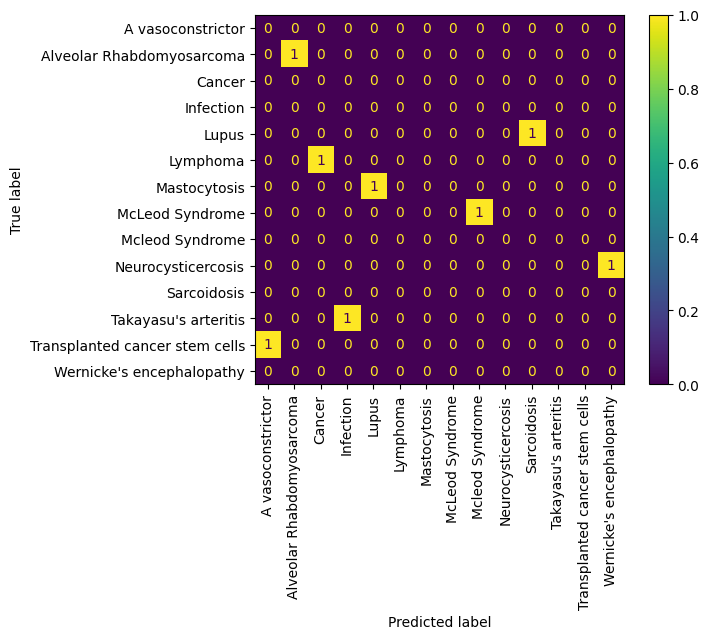

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
llm_predictions = {
    "Season 1": "Wernicke's encephalopathy",
    "Season 2": "Alveolar Rhabdomyosarcoma",
    "Season 3": "Infection",
    "Season 4": "Sarcoidosis",
    "Season 5": "A vasoconstrictor",
    "Season 6": "Cancer",
    "Season 7": "Mcleod Syndrome",
    "Season 8": "Lupus"
}
ground_truth = {
    "Season 1": "Neurocysticercosis",
    "Season 2": "Alveolar Rhabdomyosarcoma",
    "Season 3": "Takayasu's arteritis",
    "Season 4": "Lupus",
    "Season 5": "Transplanted cancer stem cells",
    "Season 6": "Lymphoma",
    "Season 7": "McLeod Syndrome",
    "Season 8": "Mastocytosis"
}
df = pd.DataFrame({
    "Season": list(llm_predictions.keys()),
    "LLM_Prediction": [llm_predictions[s] for s in llm_predictions],
    "True_Diagnosis": [ground_truth[s] for s in llm_predictions]
})
df["Match"] = df["LLM_Prediction"].str.lower() == df["True_Diagnosis"].str.lower()
accuracy = df["Match"].mean() * 100

print("LLM Diagnostic Accuracy: {:.2f}%".format(accuracy))
print(df)
labels = sorted(set(ground_truth.values()) | set(llm_predictions.values()))
y_true = [ground_truth[s] for s in llm_predictions]
y_pred = [llm_predictions[s] for s in llm_predictions]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

=== LLM Diagnosis Evaluation (Strict + Partial Credit) ===
  season                                       pred_dx                        true_dx  similarity    pred_cat    true_cat   outcome
Season 1                     Wernicke's encephalopathy             Neurocysticercosis       0.190       neuro   infection Incorrect
Season 2 Tuberous Sclerosis; Alveolar Rhabdomyosarcoma      Alveolar Rhabdomyosarcoma       1.000      cancer      cancer   Correct
Season 3                                     Infection           Takayasu's arteritis       0.214   infection  autoimmune Incorrect
Season 4                                   Sarcoidosis                          Lupus       0.125              autoimmune Incorrect
Season 5                             A vasoconstrictor Transplanted cancer stem cells       0.255                  cancer Incorrect
Season 6                                        Cancer                       Lymphoma       0.143      cancer      cancer   Partial
Season 7         

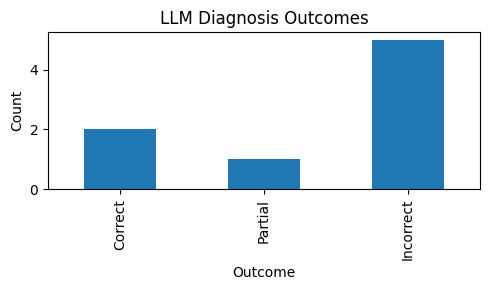

In [16]:
import re
from difflib import SequenceMatcher

llm_predictions = {
    "Season 1": "Wernicke's encephalopathy",
    "Season 2": "Tuberous Sclerosis; Alveolar Rhabdomyosarcoma",
    "Season 3": "Infection",
    "Season 4": "Sarcoidosis",
    "Season 5": "A vasoconstrictor",
    "Season 6": "Cancer",
    "Season 7": "McLeod Syndrome",
    "Season 8": "Lupus"
}

ground_truth = {
    "Season 1": "Neurocysticercosis",
    "Season 2": "Alveolar Rhabdomyosarcoma",
    "Season 3": "Takayasu's arteritis",
    "Season 4": "Lupus",
    "Season 5": "Transplanted cancer stem cells",
    "Season 6": "Lymphoma",
    "Season 7": "McLeod Syndrome",
    "Season 8": "Mastocytosis"
}
def normalize(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.lower().strip()
    s = re.sub(r"['’]", "", s)
    s = re.sub(r"[-_/]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

def fuzzy(a: str, b: str) -> float:
    return SequenceMatcher(None, normalize(a), normalize(b)).ratio()

CATEGORY_MAP = {
    "lymphoma": "cancer",
    "hodgkin": "cancer",
    "rhabdomyosarcoma": "cancer",
    "cancer": "cancer",
    "transplanted cancer stem cells": "cancer",

    "neurocysticercosis": "infection",
    "mastocytosis": "immune",
    "infection": "infection",

    "lupus": "autoimmune",
    "takayasu": "autoimmune",
    "arteritis": "autoimmune",

    "encephalopathy": "neuro",
    "wernicke": "neuro",
    "mcleod": "hematologic"
}

def coarse_category(s: str) -> str:
    s_norm = normalize(s)
    for key, cat in CATEGORY_MAP.items():
        if key in s_norm:
            return cat
    return ""

def evaluate_case(pred: str, gold: str, fuzzy_thresh=0.78):
    """Return strict/lenient flags + best similarity + categories."""
    pred_items = [p.strip() for p in re.split(r"[;,]", pred) if p.strip()]
    gold_items = [g.strip() for g in re.split(r"[;,]", gold) if g.strip()]

    exact_hit = False
    fuzzy_hit = False
    contains_true = False
    best_sim = 0.0

    for p in pred_items:
        for g in gold_items:
            sim = fuzzy(p, g)
            best_sim = max(best_sim, sim)
            if normalize(p) == normalize(g):
                exact_hit = True
            if sim >= fuzzy_thresh:
                fuzzy_hit = True
            if normalize(g) in normalize(p):
                contains_true = True

    strict = bool(exact_hit or fuzzy_hit or contains_true)

    pred_cat = coarse_category(pred)
    gold_cat = coarse_category(gold)
    partial_cat = (not strict) and (pred_cat != "" and gold_cat != "" and pred_cat == gold_cat)

    lenient = bool(strict or partial_cat)

    return {
        "best_similarity": round(best_sim, 3),
        "strict_correct": strict,
        "partial_match": partial_cat,
        "lenient_correct": lenient,
        "pred_category": pred_cat,
        "true_category": gold_cat
    }

rows = []
for season in ground_truth:
    pred = llm_predictions.get(season, "")
    gold = ground_truth[season]
    res = evaluate_case(pred, gold)
    outcome = "Correct" if res["strict_correct"] else ("Partial" if res["partial_match"] else "Incorrect")
    rows.append({
        "season": season,
        "pred_dx": pred,
        "true_dx": gold,
        "similarity": res["best_similarity"],
        "pred_cat": res["pred_category"],
        "true_cat": res["true_category"],
        "outcome": outcome,
        "strict_correct": res["strict_correct"],
        "lenient_correct": res["lenient_correct"]
    })

results = pd.DataFrame(rows).sort_values("season")
strict_acc = results["strict_correct"].mean()
lenient_acc = results["lenient_correct"].mean()

print("=== LLM Diagnosis Evaluation (Strict + Partial Credit) ===")
print(results[["season", "pred_dx", "true_dx", "similarity", "pred_cat", "true_cat", "outcome"]].to_string(index=False))
print("\nStrict accuracy:  {:.1%}".format(strict_acc))
print("Lenient accuracy: {:.1%}".format(lenient_acc))

counts = results["outcome"].value_counts().reindex(["Correct","Partial","Incorrect"]).fillna(0)
plt.figure(figsize=(5,3))
counts.plot(kind="bar")
plt.title("LLM Diagnosis Outcomes")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.tight_layout()
plt.show()